# Duration and Convexity: Bond Price Sensitivity Analysis

## Introduction

Duration and convexity are fundamental measures in fixed income analysis that quantify a bond's price sensitivity to interest rate changes. These concepts are essential for portfolio risk management, hedging strategies, and understanding the behavior of bond prices in different interest rate environments.

## Theoretical Framework

### Bond Pricing

The price of a bond is the present value of all future cash flows:

$$P = \sum_{t=1}^{T} \frac{C_t}{(1+y)^t}$$

where:
- $P$ = bond price
- $C_t$ = cash flow at time $t$ (coupon or principal)
- $y$ = yield to maturity (per period)
- $T$ = total number of periods

### Macaulay Duration

Macaulay duration is the weighted average time to receive the bond's cash flows:

$$D_{Mac} = \frac{1}{P} \sum_{t=1}^{T} t \cdot \frac{C_t}{(1+y)^t}$$

This can be interpreted as the "center of gravity" of the cash flows.

### Modified Duration

Modified duration measures the percentage price change for a 1% change in yield:

$$D_{Mod} = \frac{D_{Mac}}{1+y}$$

The price change approximation using modified duration is:

$$\frac{\Delta P}{P} \approx -D_{Mod} \cdot \Delta y$$

### Convexity

Convexity measures the curvature of the price-yield relationship and provides a second-order correction:

$$C = \frac{1}{P} \sum_{t=1}^{T} \frac{t(t+1) \cdot C_t}{(1+y)^{t+2}}$$

The improved price change approximation including convexity is:

$$\frac{\Delta P}{P} \approx -D_{Mod} \cdot \Delta y + \frac{1}{2} C \cdot (\Delta y)^2$$

### Dollar Duration and Dollar Convexity

For absolute price changes:

$$\text{Dollar Duration} = D_{Mod} \cdot P$$

$$\text{Dollar Convexity} = C \cdot P$$

### Key Properties

1. **Duration increases with maturity** (for most bonds)
2. **Duration decreases with coupon rate** (higher coupons mean earlier cash flows)
3. **Duration decreases with yield** (higher discount rates weight near-term cash flows more)
4. **Convexity is always positive** for option-free bonds
5. **Higher convexity is beneficial** - bonds gain more when yields fall than they lose when yields rise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# Set style for publication-quality plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

In [2]:
class Bond:
    """
    A class to represent a fixed-coupon bond and compute its risk measures.
    
    Parameters
    ----------
    face_value : float
        Par value of the bond
    coupon_rate : float
        Annual coupon rate (as decimal)
    maturity : float
        Time to maturity in years
    frequency : int
        Coupon payment frequency per year (1=annual, 2=semi-annual)
    """
    
    def __init__(self, face_value, coupon_rate, maturity, frequency=2):
        self.face_value = face_value
        self.coupon_rate = coupon_rate
        self.maturity = maturity
        self.frequency = frequency
        self.periods = int(maturity * frequency)
        self.coupon_payment = (coupon_rate * face_value) / frequency
    
    def get_cash_flows(self):
        """Generate the cash flow schedule."""
        cash_flows = np.full(self.periods, self.coupon_payment)
        cash_flows[-1] += self.face_value  # Add principal at maturity
        times = np.arange(1, self.periods + 1) / self.frequency
        return times, cash_flows
    
    def price(self, ytm):
        """
        Calculate the bond price given yield to maturity.
        
        Parameters
        ----------
        ytm : float
            Annual yield to maturity (as decimal)
        
        Returns
        -------
        float
            Bond price
        """
        times, cash_flows = self.get_cash_flows()
        y_per_period = ytm / self.frequency
        periods = times * self.frequency
        discount_factors = (1 + y_per_period) ** (-periods)
        return np.sum(cash_flows * discount_factors)
    
    def yield_to_maturity(self, price):
        """
        Calculate the yield to maturity given the bond price.
        
        Parameters
        ----------
        price : float
            Current bond price
        
        Returns
        -------
        float
            Annual yield to maturity
        """
        def objective(y):
            return self.price(y) - price
        return brentq(objective, 0.0001, 1.0)
    
    def macaulay_duration(self, ytm):
        """
        Calculate Macaulay duration.
        
        Parameters
        ----------
        ytm : float
            Annual yield to maturity
        
        Returns
        -------
        float
            Macaulay duration in years
        """
        times, cash_flows = self.get_cash_flows()
        y_per_period = ytm / self.frequency
        periods = times * self.frequency
        discount_factors = (1 + y_per_period) ** (-periods)
        pv_cash_flows = cash_flows * discount_factors
        price = np.sum(pv_cash_flows)
        weighted_times = np.sum(times * pv_cash_flows)
        return weighted_times / price
    
    def modified_duration(self, ytm):
        """
        Calculate modified duration.
        
        Parameters
        ----------
        ytm : float
            Annual yield to maturity
        
        Returns
        -------
        float
            Modified duration
        """
        mac_dur = self.macaulay_duration(ytm)
        return mac_dur / (1 + ytm / self.frequency)
    
    def convexity(self, ytm):
        """
        Calculate convexity.
        
        Parameters
        ----------
        ytm : float
            Annual yield to maturity
        
        Returns
        -------
        float
            Convexity (in years squared)
        """
        times, cash_flows = self.get_cash_flows()
        y_per_period = ytm / self.frequency
        periods = times * self.frequency
        
        # Convexity formula
        discount_factors = (1 + y_per_period) ** (-(periods + 2))
        convexity_terms = periods * (periods + 1) * cash_flows * discount_factors
        price = self.price(ytm)
        
        # Adjust for compounding frequency
        return np.sum(convexity_terms) / (price * self.frequency ** 2)
    
    def price_change_duration(self, ytm, delta_y):
        """
        Estimate price change using duration approximation.
        
        Parameters
        ----------
        ytm : float
            Current yield to maturity
        delta_y : float
            Change in yield
        
        Returns
        -------
        float
            Estimated percentage price change
        """
        mod_dur = self.modified_duration(ytm)
        return -mod_dur * delta_y
    
    def price_change_duration_convexity(self, ytm, delta_y):
        """
        Estimate price change using duration and convexity.
        
        Parameters
        ----------
        ytm : float
            Current yield to maturity
        delta_y : float
            Change in yield
        
        Returns
        -------
        float
            Estimated percentage price change
        """
        mod_dur = self.modified_duration(ytm)
        conv = self.convexity(ytm)
        return -mod_dur * delta_y + 0.5 * conv * delta_y ** 2

## Numerical Example

Let's analyze a typical corporate bond and demonstrate the calculation of duration and convexity measures.

In [3]:
# Create a sample bond
bond = Bond(
    face_value=1000,
    coupon_rate=0.06,  # 6% annual coupon
    maturity=10,       # 10 years to maturity
    frequency=2        # Semi-annual payments
)

# Current market yield
ytm = 0.05  # 5%

# Calculate key metrics
price = bond.price(ytm)
mac_dur = bond.macaulay_duration(ytm)
mod_dur = bond.modified_duration(ytm)
conv = bond.convexity(ytm)

print("Bond Characteristics:")
print(f"  Face Value: ${bond.face_value:,.2f}")
print(f"  Coupon Rate: {bond.coupon_rate*100:.2f}%")
print(f"  Maturity: {bond.maturity} years")
print(f"  Payment Frequency: {'Semi-annual' if bond.frequency == 2 else 'Annual'}")
print()
print(f"At YTM = {ytm*100:.2f}%:")
print(f"  Price: ${price:,.2f}")
print(f"  Macaulay Duration: {mac_dur:.4f} years")
print(f"  Modified Duration: {mod_dur:.4f}")
print(f"  Convexity: {conv:.4f}")
print(f"  Dollar Duration: ${mod_dur * price:,.2f}")
print(f"  Dollar Convexity: ${conv * price:,.2f}")

Bond Characteristics:
  Face Value: $1,000.00
  Coupon Rate: 6.00%
  Maturity: 10 years
  Payment Frequency: Semi-annual

At YTM = 5.00%:
  Price: $1,077.95
  Macaulay Duration: 7.7618 years
  Modified Duration: 7.5725
  Convexity: 70.6495
  Dollar Duration: $8,162.72
  Dollar Convexity: $76,156.32


## Price Sensitivity Analysis

We now compare actual price changes with duration and duration-convexity approximations across different yield changes.

In [4]:
# Analyze price changes for various yield shifts
yield_changes = np.array([-0.02, -0.01, -0.005, 0.005, 0.01, 0.02])  # -200bp to +200bp

print("Price Change Analysis:")
print("-" * 80)
print(f"{'Δy (bp)':<10} {'Actual %':<12} {'Duration %':<12} {'Dur+Conv %':<12} {'Error (Dur)':<12} {'Error (D+C)'}")
print("-" * 80)

for delta_y in yield_changes:
    # Actual price change
    new_price = bond.price(ytm + delta_y)
    actual_pct = (new_price - price) / price * 100
    
    # Duration approximation
    dur_pct = bond.price_change_duration(ytm, delta_y) * 100
    
    # Duration + Convexity approximation
    dur_conv_pct = bond.price_change_duration_convexity(ytm, delta_y) * 100
    
    # Errors
    dur_error = actual_pct - dur_pct
    dur_conv_error = actual_pct - dur_conv_pct
    
    print(f"{delta_y*10000:>6.0f}    {actual_pct:>10.4f}  {dur_pct:>10.4f}  {dur_conv_pct:>10.4f}  {dur_error:>10.4f}  {dur_conv_error:>10.4f}")

print("-" * 80)

Price Change Analysis:
--------------------------------------------------------------------------------
Δy (bp)    Actual %     Duration %   Dur+Conv %   Error (Dur)  Error (D+C)
--------------------------------------------------------------------------------
  -200       16.6598     15.1450     16.5580      1.5149      0.1019
  -100        7.9381      7.5725      7.9257      0.3656      0.0124
   -50        3.8761      3.7862      3.8746      0.0898      0.0015
    50       -3.6994     -3.7862     -3.6979      0.0868     -0.0015
   100       -7.2310     -7.5725     -7.2192      0.3415     -0.0117
   200      -13.8233    -15.1450    -13.7320      1.3216     -0.0913
--------------------------------------------------------------------------------


## Visualization

We create comprehensive visualizations to illustrate the concepts of duration and convexity.

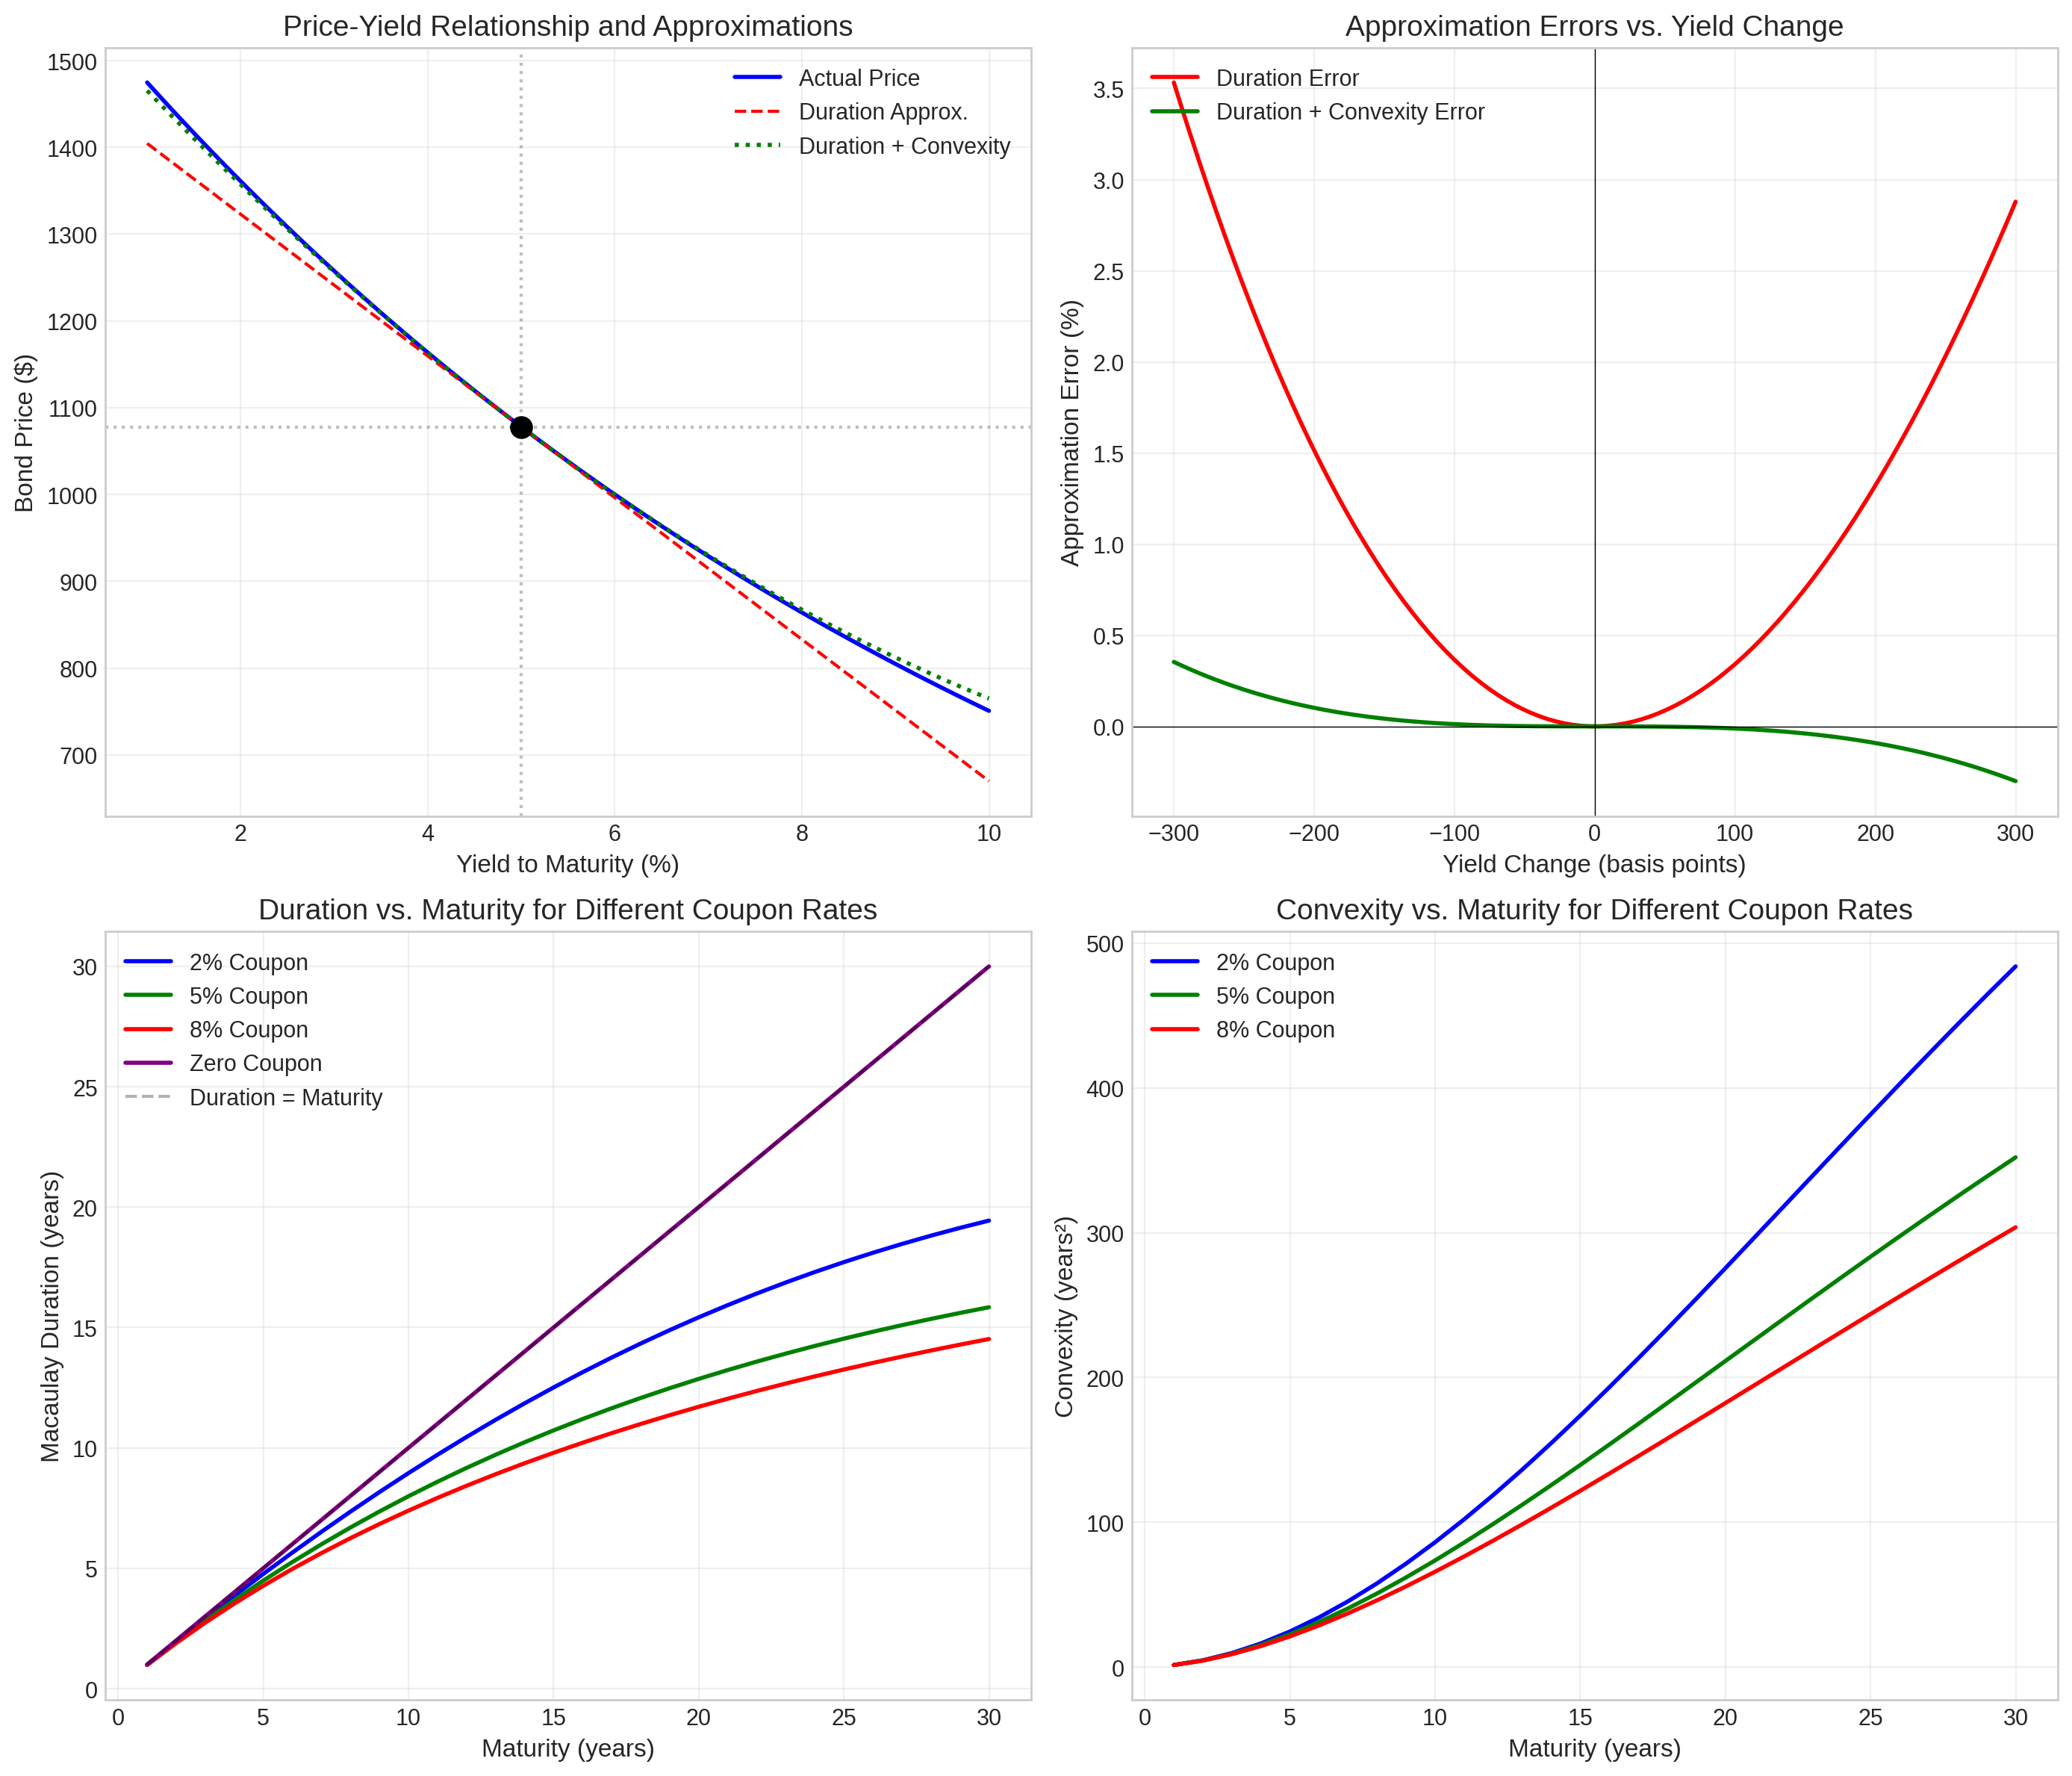


Plot saved to 'plot.png'


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Price-Yield Relationship with Approximations
ax1 = axes[0, 0]
yields = np.linspace(0.01, 0.10, 100)
actual_prices = [bond.price(y) for y in yields]

# Duration approximation (tangent line)
duration_approx = price * (1 - mod_dur * (yields - ytm))

# Duration + Convexity approximation (parabola)
dur_conv_approx = price * (1 - mod_dur * (yields - ytm) + 0.5 * conv * (yields - ytm)**2)

ax1.plot(yields * 100, actual_prices, 'b-', linewidth=2, label='Actual Price')
ax1.plot(yields * 100, duration_approx, 'r--', linewidth=1.5, label='Duration Approx.')
ax1.plot(yields * 100, dur_conv_approx, 'g:', linewidth=2, label='Duration + Convexity')
ax1.axvline(x=ytm * 100, color='gray', linestyle=':', alpha=0.5)
ax1.axhline(y=price, color='gray', linestyle=':', alpha=0.5)
ax1.scatter([ytm * 100], [price], color='black', s=100, zorder=5)

ax1.set_xlabel('Yield to Maturity (%)')
ax1.set_ylabel('Bond Price ($)')
ax1.set_title('Price-Yield Relationship and Approximations')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Approximation Errors
ax2 = axes[0, 1]
delta_yields = np.linspace(-0.03, 0.03, 100)

actual_changes = [(bond.price(ytm + dy) - price) / price * 100 for dy in delta_yields]
duration_changes = [-mod_dur * dy * 100 for dy in delta_yields]
dur_conv_changes = [(-mod_dur * dy + 0.5 * conv * dy**2) * 100 for dy in delta_yields]

dur_errors = [actual_changes[i] - duration_changes[i] for i in range(len(delta_yields))]
dur_conv_errors = [actual_changes[i] - dur_conv_changes[i] for i in range(len(delta_yields))]

ax2.plot(delta_yields * 10000, dur_errors, 'r-', linewidth=2, label='Duration Error')
ax2.plot(delta_yields * 10000, dur_conv_errors, 'g-', linewidth=2, label='Duration + Convexity Error')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

ax2.set_xlabel('Yield Change (basis points)')
ax2.set_ylabel('Approximation Error (%)')
ax2.set_title('Approximation Errors vs. Yield Change')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Duration vs. Maturity for Different Coupon Rates
ax3 = axes[1, 0]
maturities = np.linspace(1, 30, 30)
coupon_rates = [0.02, 0.05, 0.08, 0.00]  # Include zero-coupon
colors = ['blue', 'green', 'red', 'purple']
labels = ['2% Coupon', '5% Coupon', '8% Coupon', 'Zero Coupon']

for coupon, color, label in zip(coupon_rates, colors, labels):
    durations = []
    for mat in maturities:
        temp_bond = Bond(1000, coupon, mat, 2)
        durations.append(temp_bond.macaulay_duration(0.05))
    ax3.plot(maturities, durations, color=color, linewidth=2, label=label)

# Add 45-degree line for reference (zero-coupon theoretical)
ax3.plot(maturities, maturities, 'k--', alpha=0.3, label='Duration = Maturity')

ax3.set_xlabel('Maturity (years)')
ax3.set_ylabel('Macaulay Duration (years)')
ax3.set_title('Duration vs. Maturity for Different Coupon Rates')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)

# Plot 4: Convexity vs. Maturity
ax4 = axes[1, 1]

for coupon, color, label in zip(coupon_rates[:3], colors[:3], labels[:3]):
    convexities = []
    for mat in maturities:
        temp_bond = Bond(1000, coupon, mat, 2)
        convexities.append(temp_bond.convexity(0.05))
    ax4.plot(maturities, convexities, color=color, linewidth=2, label=label)

ax4.set_xlabel('Maturity (years)')
ax4.set_ylabel('Convexity (years²)')
ax4.set_title('Convexity vs. Maturity for Different Coupon Rates')
ax4.legend(loc='upper left')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('duration_and_convexity_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Portfolio Duration and Convexity

For a portfolio of bonds, duration and convexity are calculated as weighted averages:

$$D_p = \sum_{i=1}^{n} w_i D_i$$

$$C_p = \sum_{i=1}^{n} w_i C_i$$

where $w_i$ is the market value weight of bond $i$ in the portfolio.

In [6]:
# Create a small bond portfolio
portfolio = [
    {'name': 'Short-term', 'bond': Bond(1000, 0.04, 2, 2), 'quantity': 100},
    {'name': 'Medium-term', 'bond': Bond(1000, 0.05, 5, 2), 'quantity': 150},
    {'name': 'Long-term', 'bond': Bond(1000, 0.06, 10, 2), 'quantity': 75},
]

ytm = 0.05  # Assume flat yield curve for simplicity

print("Portfolio Analysis:")
print("=" * 70)

# Calculate individual bond metrics
total_value = 0
weighted_duration = 0
weighted_convexity = 0

for item in portfolio:
    bond = item['bond']
    qty = item['quantity']
    price = bond.price(ytm)
    value = price * qty
    duration = bond.modified_duration(ytm)
    convexity = bond.convexity(ytm)
    
    total_value += value
    item['price'] = price
    item['value'] = value
    item['duration'] = duration
    item['convexity'] = convexity

# Calculate weights and portfolio metrics
print(f"{'Bond':<15} {'Price':<10} {'Quantity':<10} {'Value':<15} {'Weight':<10} {'Mod Dur':<10} {'Convexity'}")
print("-" * 70)

for item in portfolio:
    weight = item['value'] / total_value
    item['weight'] = weight
    weighted_duration += weight * item['duration']
    weighted_convexity += weight * item['convexity']
    
    print(f"{item['name']:<15} ${item['price']:<8.2f} {item['quantity']:<10} ${item['value']:<13,.2f} {weight*100:<8.1f}% {item['duration']:<10.4f} {item['convexity']:.4f}")

print("-" * 70)
print(f"{'Portfolio':<15} {'':<10} {'':<10} ${total_value:<13,.2f} {'100.0':<8}% {weighted_duration:<10.4f} {weighted_convexity:.4f}")
print()
print(f"Portfolio Modified Duration: {weighted_duration:.4f}")
print(f"Portfolio Convexity: {weighted_convexity:.4f}")
print(f"Portfolio Dollar Duration: ${weighted_duration * total_value:,.2f}")

Portfolio Analysis:
Bond            Price      Quantity   Value           Weight     Mod Dur    Convexity
----------------------------------------------------------------------
Short-term      $981.19   100        $98,119.01     29.8    % 1.8940     4.5732
Medium-term     $1000.00  150        $150,000.00    45.6    % 4.3760     22.6123
Long-term       $1077.95  75         $80,845.94     24.6    % 7.5725     70.6495
----------------------------------------------------------------------
Portfolio                             $328,964.95    100.0   % 4.4213     29.0374

Portfolio Modified Duration: 4.4213
Portfolio Convexity: 29.0374
Portfolio Dollar Duration: $1,454,442.29


## Immunization and Hedging

Duration matching is used to immunize a portfolio against interest rate risk. For a liability with duration $D_L$, we construct a portfolio such that:

$$D_p = D_L$$

For complete immunization, we also match convexity to minimize the impact of non-parallel yield curve shifts.

In [7]:
# Example: Immunize a 7-year liability using two bonds
target_duration = 7.0  # Target duration for immunization
investment_amount = 1000000  # $1 million

# Two bonds for duration matching
bond_short = Bond(1000, 0.04, 3, 2)
bond_long = Bond(1000, 0.06, 15, 2)

ytm = 0.05

# Calculate durations
dur_short = bond_short.modified_duration(ytm)
dur_long = bond_long.modified_duration(ytm)

# Solve for weights: w_s * D_s + w_l * D_l = D_target, w_s + w_l = 1
weight_long = (target_duration - dur_short) / (dur_long - dur_short)
weight_short = 1 - weight_long

# Calculate allocations
price_short = bond_short.price(ytm)
price_long = bond_long.price(ytm)

value_short = weight_short * investment_amount
value_long = weight_long * investment_amount

qty_short = value_short / price_short
qty_long = value_long / price_long

# Portfolio convexity
conv_short = bond_short.convexity(ytm)
conv_long = bond_long.convexity(ytm)
portfolio_convexity = weight_short * conv_short + weight_long * conv_long

print("Duration Immunization Strategy:")
print("=" * 60)
print(f"Target Duration: {target_duration:.2f} years")
print(f"Investment Amount: ${investment_amount:,.2f}")
print()
print("Bond Allocations:")
print(f"  3-Year Bond (Duration = {dur_short:.4f}):")
print(f"    Weight: {weight_short*100:.2f}%")
print(f"    Value: ${value_short:,.2f}")
print(f"    Quantity: {qty_short:.2f} bonds")
print()
print(f"  15-Year Bond (Duration = {dur_long:.4f}):")
print(f"    Weight: {weight_long*100:.2f}%")
print(f"    Value: ${value_long:,.2f}")
print(f"    Quantity: {qty_long:.2f} bonds")
print()
print(f"Portfolio Duration: {weight_short * dur_short + weight_long * dur_long:.4f}")
print(f"Portfolio Convexity: {portfolio_convexity:.4f}")

Duration Immunization Strategy:
Target Duration: 7.00 years
Investment Amount: $1,000,000.00

Bond Allocations:
  3-Year Bond (Duration = 2.7847):
    Weight: 42.42%
    Value: $424,186.41
    Quantity: 436.20 bonds

  15-Year Bond (Duration = 10.1053):
    Weight: 57.58%
    Value: $575,813.59
    Quantity: 521.26 bonds

Portfolio Duration: 7.0000
Portfolio Convexity: 80.2497


## Conclusion

Duration and convexity are essential tools for fixed income analysis:

1. **Duration** provides a first-order approximation of price sensitivity to yield changes
2. **Convexity** improves the approximation by accounting for the curvature of the price-yield relationship
3. **Portfolio metrics** are calculated as weighted averages of individual bond measures
4. **Immunization strategies** use duration (and convexity) matching to hedge interest rate risk

These concepts form the foundation for more advanced fixed income analysis, including key rate duration, effective duration for bonds with embedded options, and dynamic hedging strategies.